In [13]:
import pandas 
from biotite.sequence.io.fasta import FastaFile

In [16]:
headers = []
sequences = []
lengths = []

fn = FastaFile.read("./hypf-raw.txt")

for header, sequence in fn.items():
    
    header = header.split("|")[1]
    sequence = str(sequence)
    length = len(sequence)
    
    headers.append(header)
    sequences.append(sequence)
    lengths.append(length)

print(f"{len(headers)} sequences")

28856 sequences


array([[<Axes: title={'center': 'length'}>]], dtype=object)

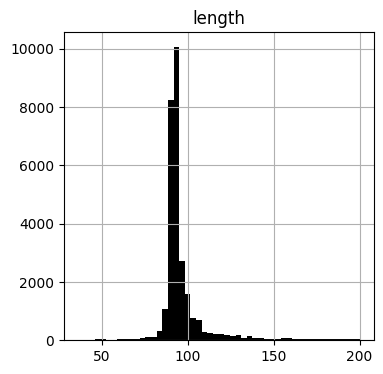

In [17]:
df = pandas.DataFrame({
    "header": headers, 
    "sequence": sequences, 
    "length": lengths, 
})

df.hist("length", bins=50, color="black", figsize=(4, 4))

In [19]:
orig_shape = df.shape 

df = df[
    (df["sequence"].str.startswith("M")) & 
    (df["length"] >= 64) & 
    (df["length"] < 128)   # so the block_size ends up at 128 
]

orig_shape, df.shape 

((28856, 3), (26856, 3))

In [20]:
df.to_csv("hypf.csv", index=False)

with open("hypf.fa", "w") as fn:
    for idx, row in df.iterrows():
        line = f">{row['header']}\n{row['sequence']}\n"
        fn.write(line)

! head -8 hypf.fa 

>A0A0A0MQQ1
MCLLSLAAATVAARRTPLRLLGRGLAAAMSTAGPLKSVDYEVFGRVQGVCFRMYTEGEAKKIGVVGWVKNTSKGTVTGQVQGPEDKVNSMKSWLSKVGSPSSRIDRTNFSNEKTISKLEYSNFSIRY
>A0A0J9R170
MSSQIKKSKTTTKKLVKSAPKSVPNAAADDQIFCCQFEVFGHVQDFSGVFFRKHTQKKANELGITGWCMNTTRGTVQGMLEGSLDQMTDMKYWLQHKGSPRSVIEKAVFSENEALPINNFKMFSIRR
>A0A0L7RIB7
MLTKLYLKIVLCLLVALPFLSEVTSQNTDTTMTKLVGVDFEVYGRVQGVFFRKYTQKHSTELGLKGWCMNTDKGTVVGRIEGEKEKVEQMKNWLRYTGSPQSAIDKAEFKNEKELSQPSFTNFEIKK
>A0A1B2IV65
MTTNRTVVALLHKLRKLRDWYVITQANGVTLPETTTEPITRVHYVFHGKVQKVGFRLLLKTIADRMHLTGWVMNNDNLDVVAEVQGTPTQLAFIKHYLSTGVKRIQVAQIEERQADIALNEHQFIIK


In [21]:
# add in active site data 

metadata = pandas.read_csv("./metadata.txt", sep="\t", index_col=0)

example = metadata.iloc[0, -1]

example 

'ACT_SITE 18; /evidence="ECO:0000256|PROSITE-ProRule:PRU00520"; ACT_SITE 36; /evidence="ECO:0000256|PROSITE-ProRule:PRU00520"'

In [22]:
metadata.columns

Index(['Entry Name', 'Protein names', 'Gene Names', 'Organism', 'Length',
       'Taxonomic lineage', 'Active site'],
      dtype='object')

In [23]:
import re 

In [24]:
import numpy 

In [25]:
active_site_1 = []
active_site_2 = []
taxons = []
for idx, row in metadata.iterrows():
    my_active_site = []
    for x in re.findall("ACT_SITE (\d+);", row["Active site"]):
        my_active_site.append(int(x))
    active_site_1 = my_active_site[0]
    active_site_2 = my_active_site[1] if len(my_active_site) > 1 else None 

    line = row["Taxonomic lineage"]
    taxon = "other"
    if "Euk" in line:
        taxon = "eukaryote"
    if "Archaea" in line:
        taxon = "archean"
    if "Bacteria" in line:
        taxon = "bacteria"
    taxons.append(taxon)

metadata["act_1"] = active_site_1
metadata["act_2"] = active_site_2
metadata["taxon"] = taxons
metadata["length"] = metadata["Length"]

metadata = metadata.loc[headers, ["act_1", "act_2", "length", "taxon"]]

metadata = metadata.dropna() 

<Axes: >

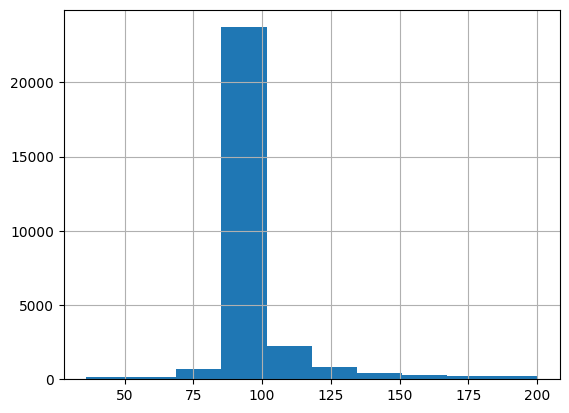

In [26]:
metadata["length"].hist()

In [27]:
metadata["taxon"].value_counts() 

taxon
bacteria     23138
eukaryote     2996
archean       2722
Name: count, dtype: int64